In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

678 genes excluded.


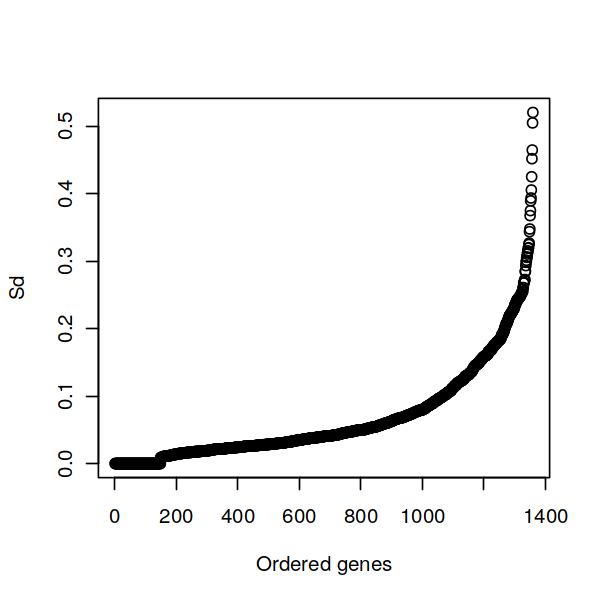

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-FL-aLP1_5to0-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

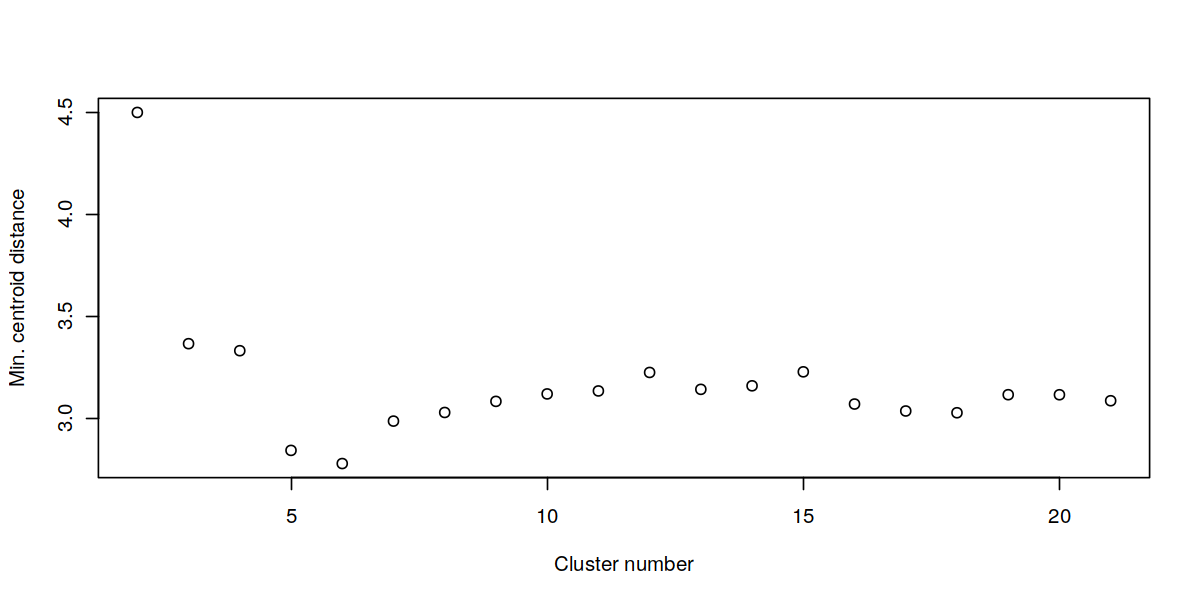

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


Warning message:
“Ignoring unknown aesthetics: order”


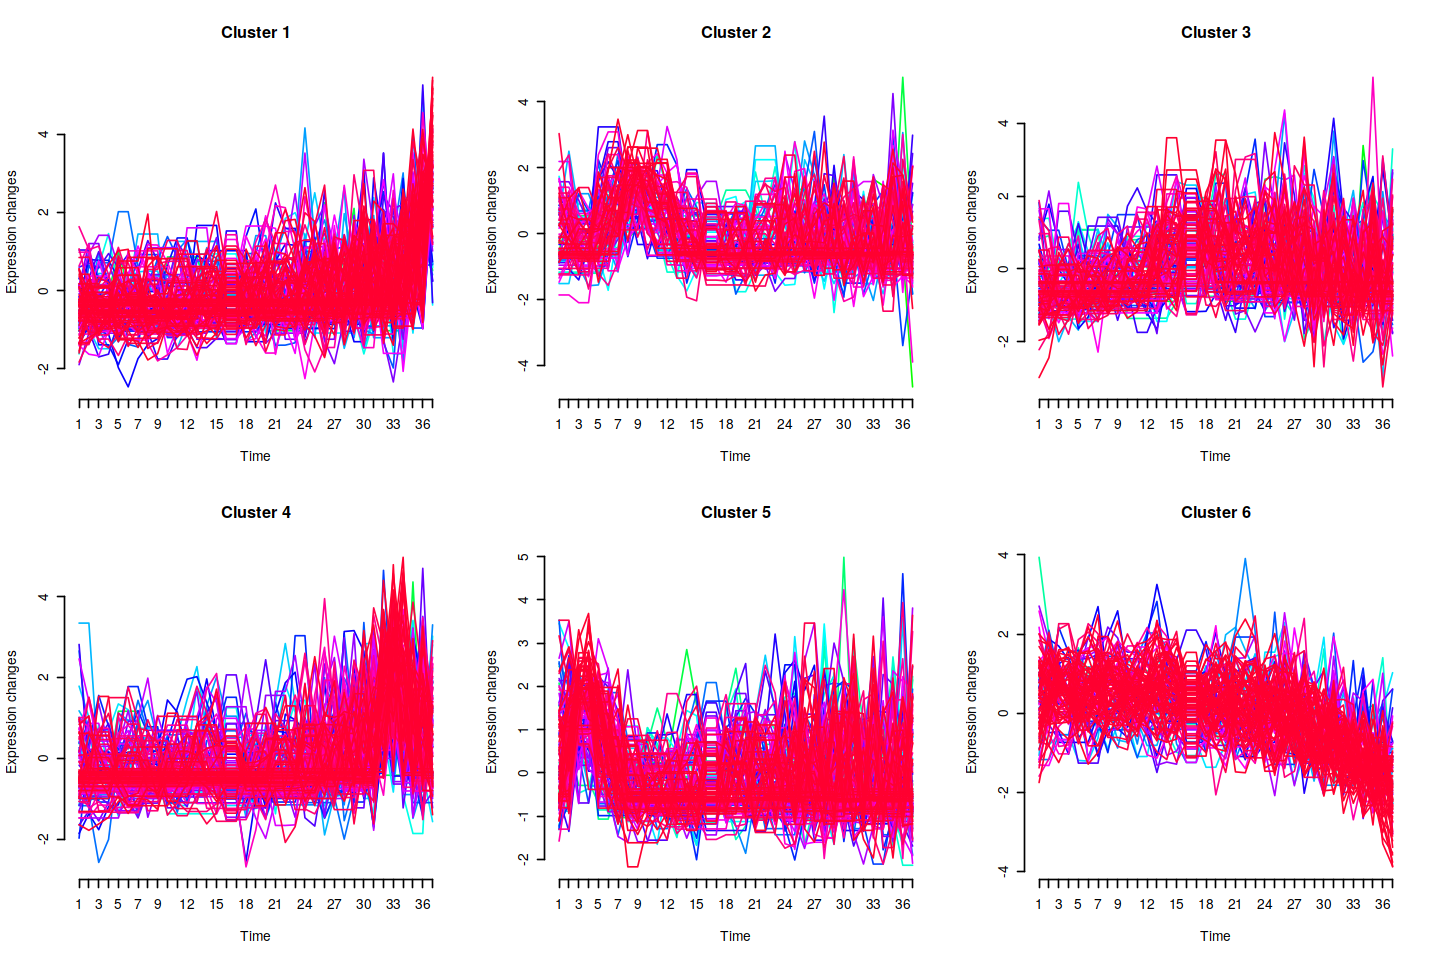

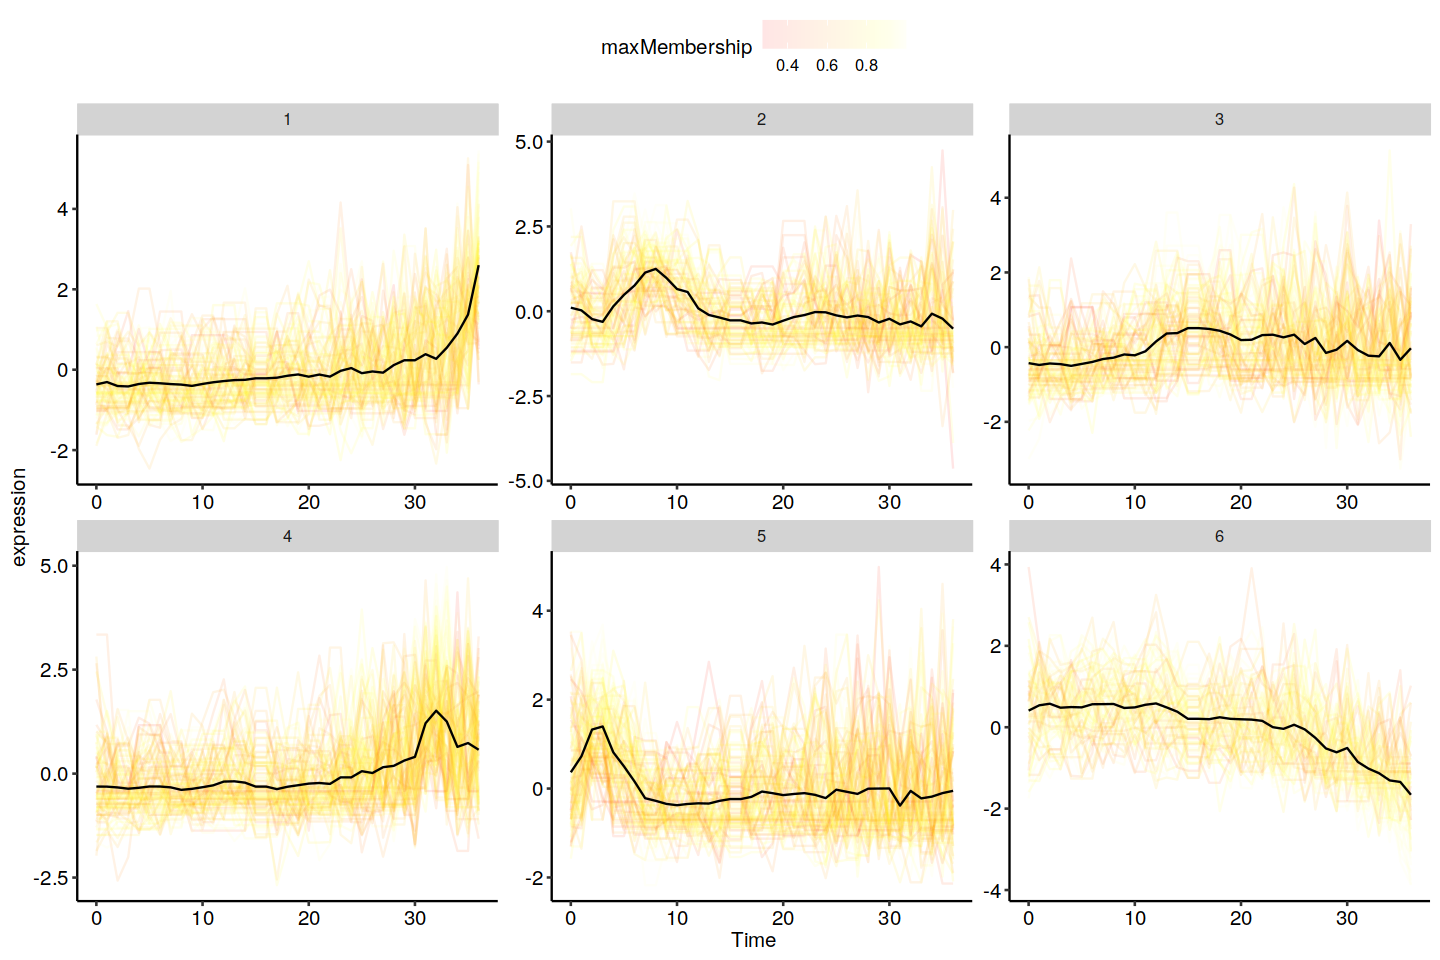

In [7]:
# 3. do clustering and show
c <- 6 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(2,3), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=3)

In [8]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 129  91 106 128 126 101

In [9]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [10]:
res1 <- path.enrichment.analysis(1)
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)
res6 <- path.enrichment.analysis(6)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“0.88% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.05% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“3.41% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.66% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“6.67% of input gene

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


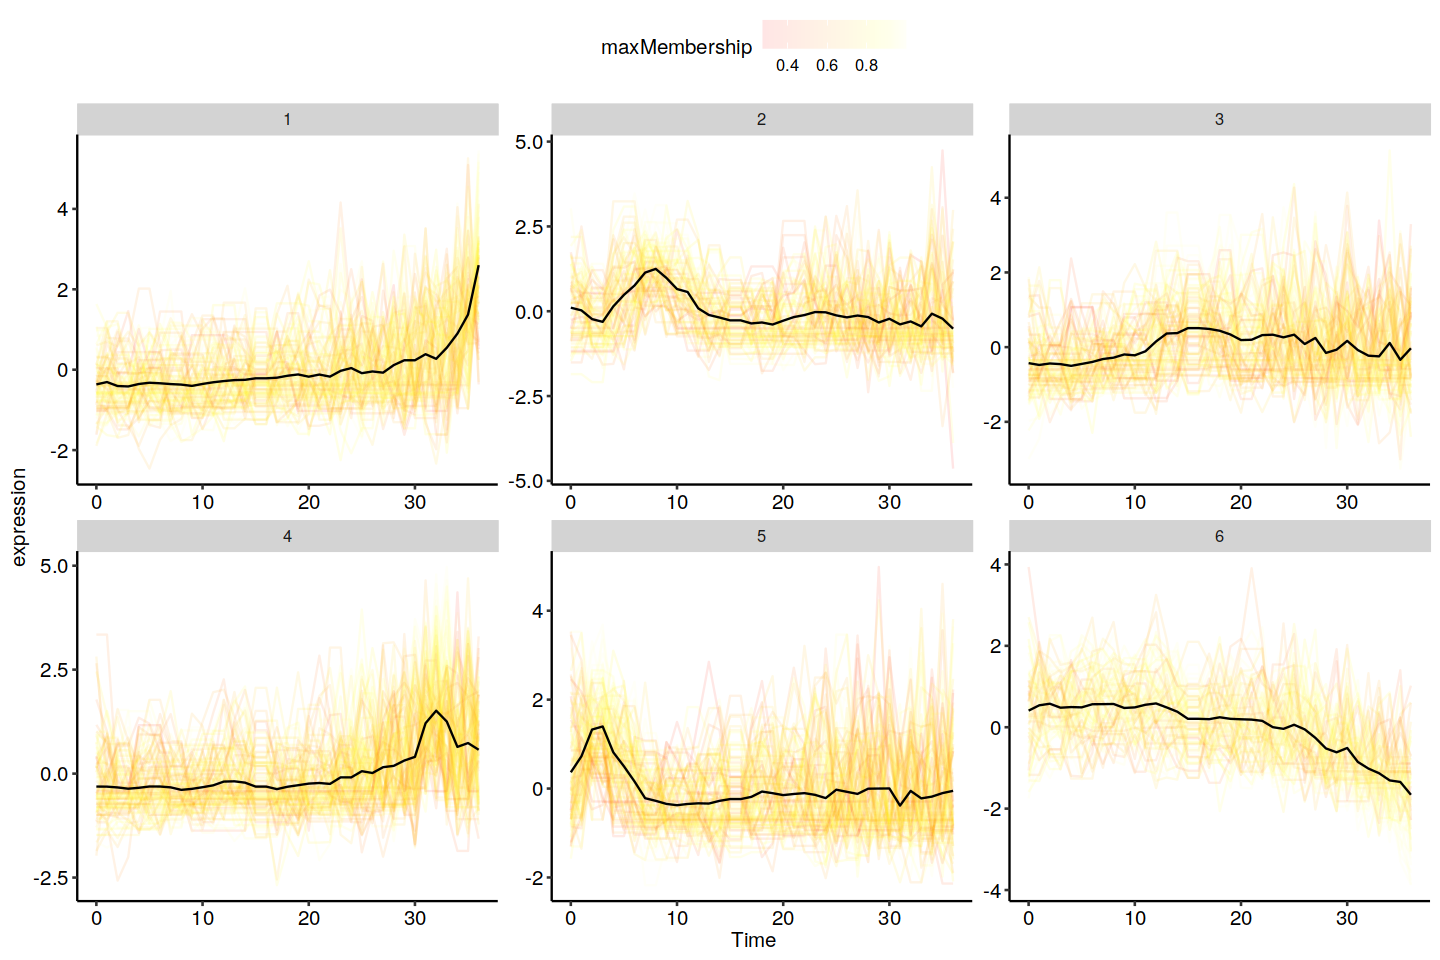

In [11]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=3)

## C1

In [12]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



[1] "Genes:"
Pirb Cd74 Ddit4l Cd7 Shisa5 Calm4 Ptms Wfdc18 Tyrobp Zfp36l1 6330403K07Rik Sema3d Ctsa Napsa Necab2 Wfdc17 Slc46a3 Vsir Ly86 Clec4a2 Klrd1 Ppp1r15a Inpp5f Cd9 Ifi35 Evl Psap Cd200r1 H2-DMb2 Snai3 Tspan13 Eya2 4930481A15Rik H2-T23 Basp1 Serp1 Ifi203 Nucb2 Sirpa Fam49a Phf11c Hsd11b1 Mndal Gsn Tapbp Ctss Pld4 Tcf4 Id2 Yipf2 Fzr1 Ppp3ca Jund Selenop Il18 Anxa6 Rnase6 Nfam1 Unc93b1 Mxd4 Hoxa9 Tmsb15b1 Fam117b Cd52 Gm2a Cyba Alox5ap Lgals3 Socs3 Il21r Tnfaip8l2 Rrad Ighm H2-DMa Arid3a Acadm Ccl3 Tpd52 Plp2 Ypel3 Tnni2 Nmrk1 Paip2b Cln8 Trbc2 Gm5086 Stk17b Ighv1-77 Evi5 Abhd6 Cd69 Ltb Lsp1 Grina Cyth4 Cst3 Rtp4 Vasp Mfap2 Tspan32 Pltp Junb Ckb Maged1 Tifab Ppfia4 Tmem119 Btg1 Zcchc18 Fth1 Lgals9 Capsl Il1r2NULL
[1] "TFs:"
Cd7 Zfp36l1 Snai3 Eya2 Tcf4 Id2 Jund Mxd4 Hoxa9 Arid3a JunbNULL


## C2

In [13]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



[1] "Genes:"
Perp Eps15 Zbtb16 Zbtb20 Platr17 Cd6 Acp5 Mtss1 Hbb-bt Mgst2 Ly6d Mindy2 Fyb Cd82 Csf2ra Cdkn2d Endov Ccna2 Lyz2 Pld3 Mis18bp1 Tuba8 Gm47283 Sox4 P2rx4 Tmem176a Hbb-bs Ccnf Prc1 Spaca9 Pkig Tmem121 Mta3 Dnajc7 Gpr132 Klf2 Tcp11l2 Serpinf1 Lgals8 Calr Nfkbie H2-Ab1 Cks2 Id1 Uhrf1 Stmn1 Dusp2 Il12a Usp37 Selenos Oaf Nfkbia Ccnd3 Nfkbid Dnajb14 Terf2ip Kif2c S100a4 Cd24a Apoc1 Kifc1 Selplg Kctd14 Dennd1c 4931406C07Rik Camk2a Gm49169 Gstm5 Grhpr Srebf2 Sell Pycard Atp1b3 RgccNULL
[1] "TFs:"
Zbtb16 Zbtb20 Mis18bp1 Sox4 Mta3 Klf2 Id1 Nfkbia Srebf2NULL


## C3

[1] "Genes:"
Emb Ccnd2 Abhd17b Ncapd2 Slc8b1 Ctr9 Tmem108 Manf Slco4a1 Smad7 Runx2os1 Tuba1c S100a6 Mid1ip1 Tmem158 Samsn1 Cnn2 Ift57 Cd28 Ung Capn3 Zfp467 Pkib Gadd45b Hmgn2 Cks1b Serpinb1a Tfrc Rgs1 Ccnd1 Sstr2 Ifitm1 Hmgn3 Blvrb Nek6 Epsti1 Rab33b Egfl7 Slbp Gpr171 Spi1 Morc1 H2afy Xlr3b Socs1 Glipr1 Ctsz Plek Gstt2 Cd96 B930036N10Rik Slc37a2 Gimap6 Dnajb9 Cd34 Dkkl1 Paip1 Mcm2 Ier2 Ebf1 Ccne1 Pnck Il7r Gem Birc5 Lpcat2 Grap Trim55 Ehbp1l1 Prdx5 Hba-a2 Ass1 Gimap9 Pou2f2 Mt1 Nfil3 Calcoco1 Mzb1 Ifnar2 Tcf19 Ifitm3 Dok2 Usp18 Clic4 Samhd1 Fgr 1500011B03Rik Gnb4NULL
[1] "TFs:"
Ctr9 Smad7 Zfp467 Ccnd1 Hmgn3 Spi1 Plek Ebf1 Pou2f2 Nfil3 Tcf19NULL


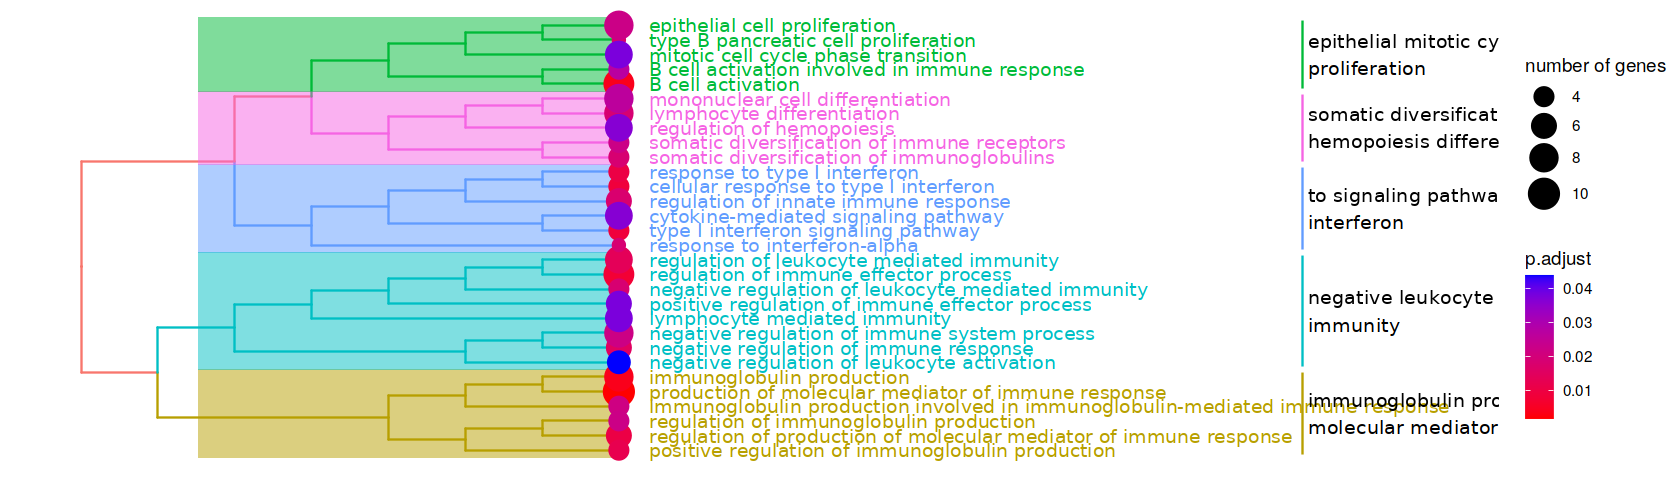

In [14]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Foxf1 Gm19331 Ctnnd2 Pacsin1 Marcks Cavin2 Rab19 Ifnar1 9230105E05Rik Hist3h2ba Maf Hist1h2bc Hic1 Ogt Pkp3 Ccnb2 Rgs2 Clec2i Isg15 Tsc22d1 2610035D17Rik Rhoh Tcta Rasgrp4 Arid5b Eva1b Ier3 Cdkn1c Tmem51 Cd81 Lpar6 Sp100 Agpat3 Sema4b Capg Setd4 Jchain Ier5 I830077J02Rik Fcgr3 Itm2c Rgs10 Lppos Cfp Prr13 Notch1 Ccl4 Lockd Btg2 Pbxip1 Hoxa7 Ccr7 Car2 Lax1 Ifi27 Lgmn Hlx Gpcpd1 Irf7 Blcap Lmo4 Ccr9 H2afv Tmeff2 Vim Tnfrsf13c Kdm5b Jup Scpep1 Ebi3 Cd72 Pdcd1 Sh2d3c Lck Ctso Arl6ip1 Trp53i11 H2-Oa Herpud1 Plin3 Anxa5 Lst1 Grifin Plaur Tbxa2r Lztfl1 Ddit4 Hist1h2ac Cenpa Paqr5 Tpm4 Ifi27l2a 1700097N02Rik Smox S100a11 Hvcn1 9130015A21Rik Bdh1 Gfod2 Ctsb Hck Smim5 Fads3 Ptpre Gata3 Isg20NULL
[1] "TFs:"
Foxf1 Maf Hic1 Tsc22d1 Arid5b Sp100 Notch1 Btg2 Hoxa7 Hlx Irf7 Lmo4 Cenpa Gata3NULL


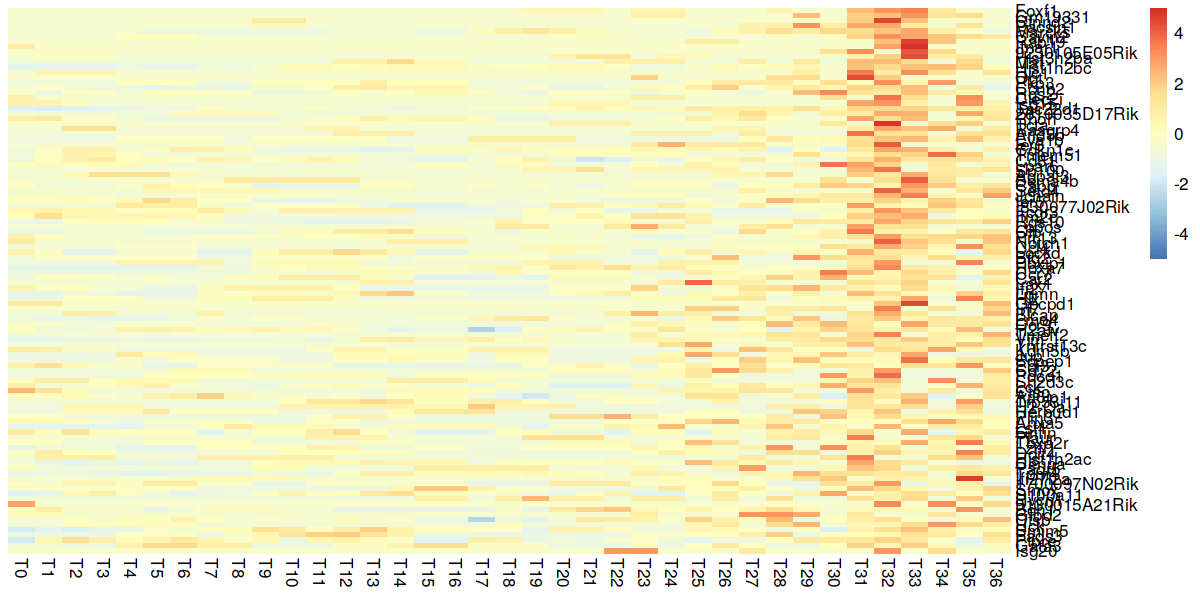

In [15]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Gm4208 Hp Hes1 Dennd5b Sapcd2 Slc43a2 2610528A11Rik Ncf4 Ube2s Naga Thy1 Ablim1 Noa1 Bst2 Tcrg-C1 Ldhb 1110008P14Rik Ms4a4b Pglyrp1 Fxyd7 Sgo1 Tpm2 Sat1 Rpgrip1 Tox Hmmr Pimreg Lgals3bp Zfp992 Fcer1g Cd3g Khk Asah1 Kif20b Gzma Nudt18 Dtl 2310001H17Rik Agl Slfn5 H19 Galnt12 Kif20a Hist1h1c Lgals1 Gm26917 Cdca3 Lta Bcl2 Klf13 Cldnd1 Il6ra Fgd2 Sla2 Trbc1 Pdlim2 Trim12a Tox2 N4bp2l1 Ctsc Aurka Mcpt8 Gm15518 Nkg7 H2-DMb1 Xlr4b Nfkb1 Spc25 Ly6e Dbt Tmem50b Tnni1 Fdps Msmo1 H2-M3 H2-D1 Cdkn3 Bfsp2 Rassf4 Dlgap4 Mki67 Ube2c Fbxo6 P2ry14 Ctsl Izumo4 Plxnc1 Anxa1 Ctsw Ptprc Gimap5 Dlgap5 Gyg Gngt2 Pdia5 Tacc3 Carhsp1 Tmem80 Irf8 Unc13d Nrgn Ctsh Ckap2l Hsp90b1 Ifitm2NULL
[1] "TFs:"
Hes1 Tox Zfp992 Klf13 Sla2 Tox2 Nfkb1 Carhsp1 Irf8NULL


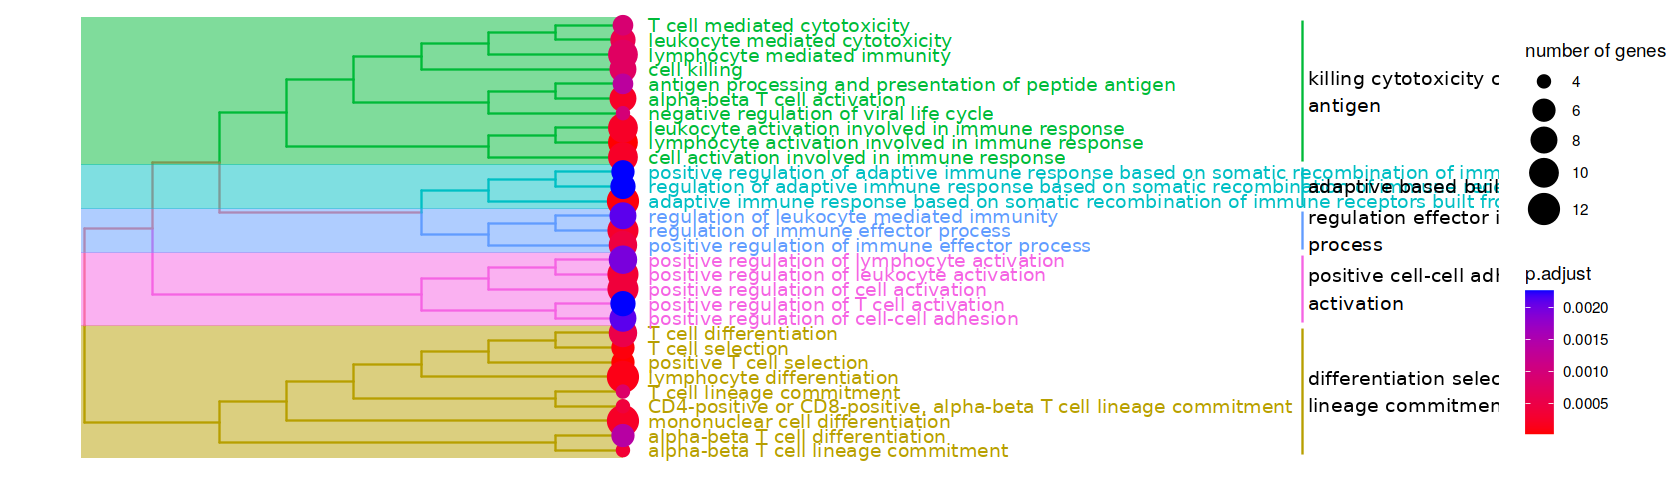

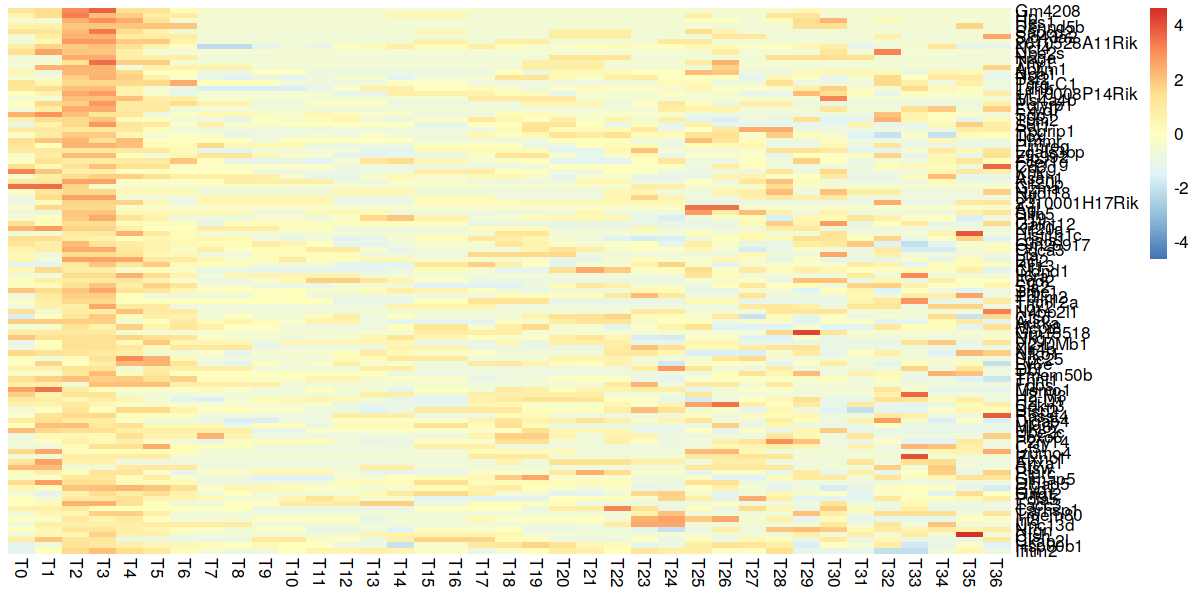

In [16]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C6

[1] "Genes:"
Rrm2 Pclaf Srm Cycs Syce2 Dut Tuba1b Ldha Asf1b Fabp5 Hist1h1b Cdk1 Ncl Ranbp1 Spc24 Mif Gmnn Mcm5 Smc4 Ran Mcm7 Kpna2 Tyms Smc2 Pbk Nasp Anp32b Comt Nucks1 Dlk1 Tubb4b Hmgb2 Cdv3 Aurkb Myc Fbxo5 Dhfr Tk1 H2afx Tubb5 Ccne2 Dek Ccnb1 Cdca7 Lig1 Hmga2 Rexo2 Tuba4a Rpa2 Tmed3 Prtn3 Rrm1 Atad2 Hells E2f1 Clspn Cdca8 Sqle Plk1 Pcna Cebpb Calm2 Hmgb3 Hspa5 Fam189b Hes6 Mpo Tipin Anxa2 Igfbp4 Kif22 Top2a Ap3s1 Cnn3 Crip1 Tspo Pim1 Cd63 Ezh2 Gfi1b Mcm3 Reep4 Myl10 Jun Mcm6 Cdkn1a Shcbp1 Auts2 Sdf2l1 Cenpe Hist1h4iNULL
[1] "TFs:"
Kpna2 Hmgb2 Myc Hmga2 E2f1 Cebpb Hmgb3 Hes6 Ezh2 Gfi1b Mcm3 Jun Mcm6NULL


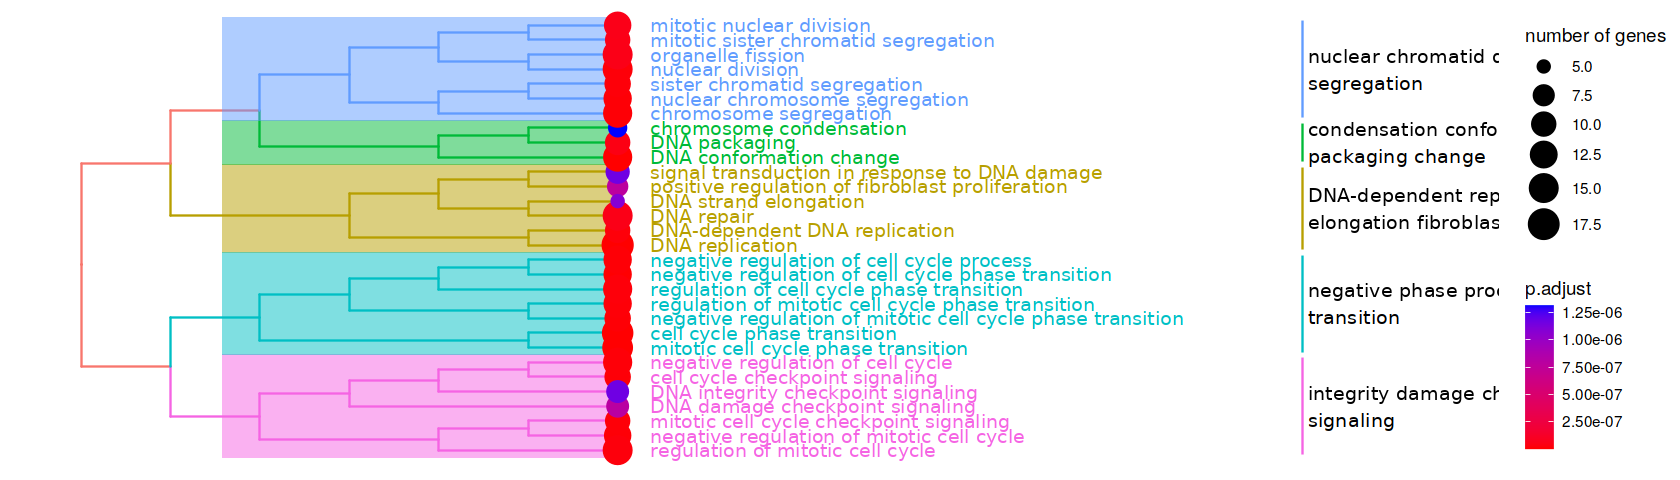

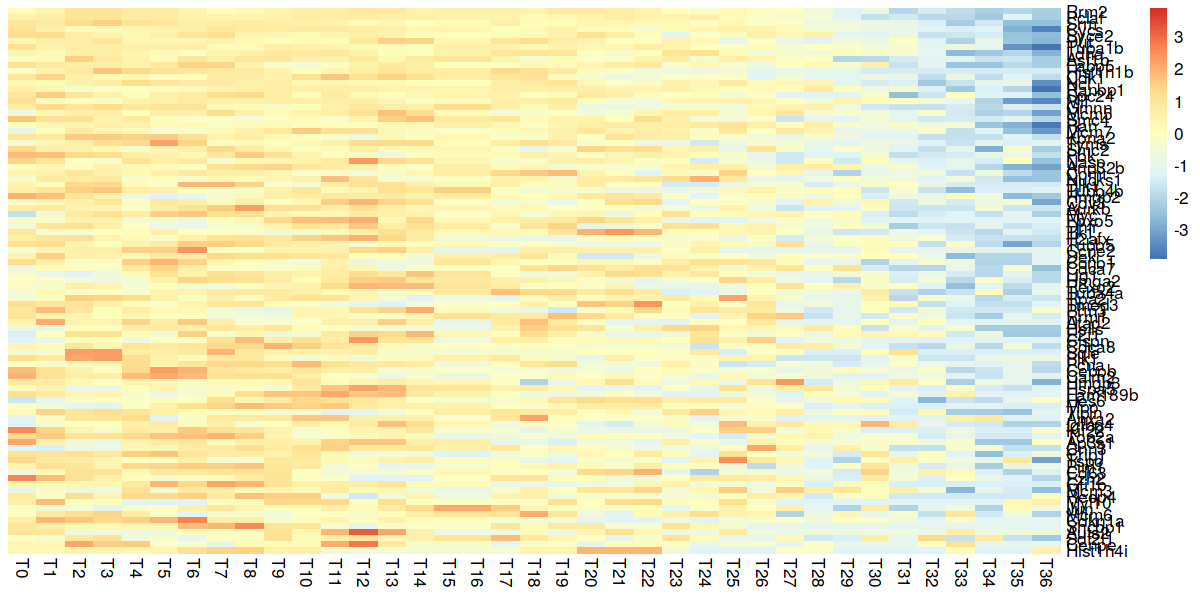

In [17]:
print('Genes:')
print(cat(res6$path.gene))#
print('TFs:')
print(cat(intersect(res6$path.gene, tf)))#

o(14,4)
plot(res6$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res6$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)

